In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm

#Constants
IMAGE_SIZE = (150, 150)

In [2]:
# Resize images
images = []
files_names = []
orig_images=[]
output = []

for file in tqdm(os.listdir("images")[1:800]):
    #print(file)
    # Get the path name of the image
    img_path = os.path.join("images", file)

    # Open and resize the img
    image = cv2.imread(img_path)

    orig_images.append(image) # the original file
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMAGE_SIZE)
    images.append(image)
    files_names.append(file)

labels = np.array(files_names)

100%|██████████| 799/799 [00:02<00:00, 354.63it/s]


In [3]:
df_assets=pd.DataFrame({"Filename":files_names, "images": images})
df_assets

,Filename,images
0,20170210-130942-0.jpg,"[[[108, 92, 102], [148, 133, 146], [69, 56, 72..."
1,20170217-103031-0.jpg,"[[[23, 19, 18], [28, 27, 25], [48, 48, 46], [4..."
2,20170210-132021-0.jpg,"[[[103, 97, 132], [185, 170, 206], [123, 97, 1..."
3,20170130-102032-0.jpg,"[[[43, 71, 42], [59, 80, 64], [49, 62, 58], [4..."
4,20170704-154648-0.jpg,"[[[111, 111, 134], [103, 104, 123], [103, 106,..."
...,...,...
794,20170405-160310-0.jpg,"[[[124, 112, 121], [34, 23, 31], [20, 15, 21],..."
795,20170126-095436-0.jpg,"[[[100, 101, 106], [184, 189, 190], [74, 89, 8..."
796,20170304-131712-0.jpg,"[[[150, 144, 156], [52, 44, 56], [220, 214, 22..."
797,20170210-131153-0.jpg,"[[[164, 159, 157], [134, 129, 132], [93, 90, 1..."


In [4]:
# Add category data
# Import CSV file
df_label = pd.read_csv("labels.csv")
df_assets= df_assets.merge(df_label, how='left', left_on="Filename", right_on="Filename")
df_assets

,Filename,images,Label,Species
0,20170210-130942-0.jpg,"[[[108, 92, 102], [148, 133, 146], [69, 56, 72...",7,Snake weed
1,20170217-103031-0.jpg,"[[[23, 19, 18], [28, 27, 25], [48, 48, 46], [4...",0,Chinee apple
2,20170210-132021-0.jpg,"[[[103, 97, 132], [185, 170, 206], [123, 97, 1...",7,Snake weed
3,20170130-102032-0.jpg,"[[[43, 71, 42], [59, 80, 64], [49, 62, 58], [4...",1,Lantana
4,20170704-154648-0.jpg,"[[[111, 111, 134], [103, 104, 123], [103, 106,...",7,Snake weed
...,...,...,...,...
794,20170405-160310-0.jpg,"[[[124, 112, 121], [34, 23, 31], [20, 15, 21],...",8,Negative
795,20170126-095436-0.jpg,"[[[100, 101, 106], [184, 189, 190], [74, 89, 8...",1,Lantana
796,20170304-131712-0.jpg,"[[[150, 144, 156], [52, 44, 56], [220, 214, 22...",7,Snake weed
797,20170210-131153-0.jpg,"[[[164, 159, 157], [134, 129, 132], [93, 90, 1...",7,Snake weed


In [5]:
# Quick breakdown of the categories of images
df_assets.groupby(["Species","Label"]).size()

Species       Label
Chinee apple  0        234
Lantana       1        160
Negative      8        145
Snake weed    7        260
dtype: int64

In [6]:
#Split the dataframe into two random samples (80% and 20%) for training and testing
train, test = train_test_split(df_assets, test_size=0.2)
train.shape

(639, 4)

## Steps are:

# Build the model,
1. Compile the model,
2. Train / fit the data to the model,
3. Evaluate the model on the testing set,

In [7]:

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3),data_format="channels_last", activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2,data_format="channels_last"),
    tf.keras.layers.Conv2D(32, (3, 3),data_format="channels_last", activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2,data_format="channels_last"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(9, activation=tf.nn.softmax)
])

2022-09-07 20:30:11.534770: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-07 20:30:11.534816: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-48-215.ap-southeast-2.compute.internal): /proc/driver/nvidia/version does not exist
2022-09-07 20:30:11.536140: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
images=np.array(list(train.loc[:,"images"]), dtype = 'float32')
labels = np.array(list(train.loc[:,"Label"]), dtype = 'int32')

model_fit = model.fit(images,labels , batch_size=128, epochs=20, validation_split = 0.2)

2022-09-07 20:30:13.054660: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 137970000 exceeds 10% of free system memory.


Epoch 1/20


2022-09-07 20:30:17.960431: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 358875136 exceeds 10% of free system memory.
2022-09-07 20:30:19.900781: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 89718784 exceeds 10% of free system memory.
2022-09-07 20:30:20.013108: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 84934656 exceeds 10% of free system memory.
2022-09-07 20:30:21.373547: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 42467328 exceeds 10% of free system memory.


4/4 [==============================] - 19s 3s/step - loss: 891.9708 - accuracy: 0.2427 - val_loss: 861.8284 - val_accuracy: 0.1719
Epoch 2/20
4/4 [==============================] - 13s 3s/step - loss: 401.9144 - accuracy: 0.2877 - val_loss: 130.0115 - val_accuracy: 0.3047
Epoch 3/20
4/4 [==============================] - 13s 3s/step - loss: 68.8148 - accuracy: 0.2935 - val_loss: 9.4906 - val_accuracy: 0.3438
Epoch 4/20
4/4 [==============================] - 13s 3s/step - loss: 3.9483 - accuracy: 0.3836 - val_loss: 2.0650 - val_accuracy: 0.3672
Epoch 5/20
4/4 [==============================] - 14s 3s/step - loss: 1.1787 - accuracy: 0.6184 - val_loss: 2.2444 - val_accuracy: 0.2969
Epoch 6/20
4/4 [==============================] - 12s 3s/step - loss: 0.9997 - accuracy: 0.6497 - val_loss: 1.9112 - val_accuracy: 0.3672
Epoch 7/20
4/4 [==============================] - 13s 3s/step - loss: 0.6399 - accuracy: 0.8395 - val_loss: 2.2797 - val_accuracy: 0.3359
Epoch 8/20
4/4 [====================

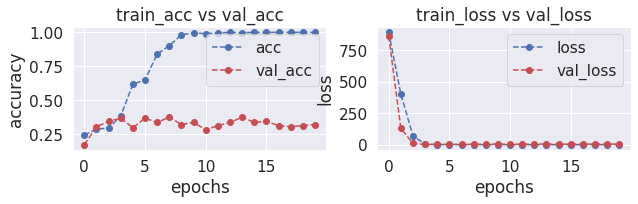

In [10]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()
plot_accuracy_loss(model_fit)

# Steps to do:
1. Run the model against the test data (continue with https://www.kaggle.com/code/vincee/intel-image-classification-cnn-keras/notebook)
2. Confuision Matrix (measure of fit) (see https://www.w3schools.com/python/python_ml_confusion_matrix.asp)
3. Display results